This file is to select lr based on the loss curve

In [1]:
import sys
sys.path.append("./mypkg")
from constants import RES_ROOT, FIG_ROOT, DATA_ROOT, MIDRES_ROOT

In [2]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from easydict import EasyDict as edict
from collections import defaultdict as ddict
import time
from pathlib import Path    
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from tqdm import trange, tqdm
plt.style.use(FIG_ROOT/"base.mplstyle")

In [3]:
%load_ext autoreload
%autoreload 2
# 0,1, 2, 3, be careful about the space

In [4]:
from utils.misc import load_pkl_folder2dict
from utils.colors import qual_cmap

# Load data and model

## Load model

In [5]:

def _load_losses(model_path):
    if isinstance(model_path, str):
        model_path = Path(model_path);
    model_utils = load_pkl_folder2dict(model_path, including=["*_params*", "loss_save*"], verbose=1);
    return  model_utils

In [62]:
cepoch = 9
#model1_name = f"RAWINPUT-MULTI_aux_lossTrue_lr100_lr_gamma10_ntrain_batch0_aux_loss_weight100_move_steps1-5-10_epoch{cepoch}_iter3568"
model1_name = f"RAWINPUT-MULTI_aux_lossTrue_lr100_lr_gamma10_ntrain_batch0_aux_loss_weight500_move_steps1-5-10_epoch{cepoch}_iter3568"
model2_name = f"RAWINPUT-MULTI_aux_lossFalse_lr100_lr_gamma10_ntrain_batch0_epoch{cepoch}_iter3568"

model1_name = f"RAWINPUT-MULTI-LONGEP_aux_lossTrue_lr100_lr_gamma10_ntrain_batch1000_aux_loss_weight500_move_steps1-5-10_epoch{cepoch}_iter1000"
model2_name = f"RAWINPUT-MULTI-LONGEP_aux_lossFalse_lr100_lr_gamma10_ntrain_batch1000_epoch{cepoch}_iter1000"

#model1_name = f"RAWINPUT-MULTI_aux_lossTrue_lr100_lr_gamma10_ntrain_batch500_aux_loss_weight500_move_steps1-5-10_epoch{cepoch}_iter500"
#model2_name = f"RAWINPUT-MULTI_aux_lossFalse_lr100_lr_gamma10_ntrain_batch500_epoch{cepoch}_iter500"

#model1_name = f"RAWINPUT_aux_lossTrue_lr100_lr_gamma10_ntrain_batch0_aux_loss_weight100_epoch{cepoch}_iter3691"
#model2_name = f"RAWINPUT_aux_lossFalse_lr100_lr_gamma10_ntrain_batch0_epoch{cepoch}_iter3691"

model1 = _load_losses(RES_ROOT/model1_name);
model2 = _load_losses(RES_ROOT/model2_name);

#model_names = ["w1", "w5"]
model_names = ["w5", "w0"]

Load file /data/rajlab1/user_data/jin/MyResearch/EEG-sz-det_dev/mypkg/../results/RAWINPUT-MULTI-LONGEP_aux_lossTrue_lr100_lr_gamma10_ntrain_batch1000_aux_loss_weight500_move_steps1-5-10_epoch9_iter1000/data_params.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/EEG-sz-det_dev/mypkg/../results/RAWINPUT-MULTI-LONGEP_aux_lossTrue_lr100_lr_gamma10_ntrain_batch1000_aux_loss_weight500_move_steps1-5-10_epoch9_iter1000/loss_save.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/EEG-sz-det_dev/mypkg/../results/RAWINPUT-MULTI-LONGEP_aux_lossTrue_lr100_lr_gamma10_ntrain_batch1000_aux_loss_weight500_move_steps1-5-10_epoch9_iter1000/train_params.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/EEG-sz-det_dev/mypkg/../results/RAWINPUT-MULTI-LONGEP_aux_lossFalse_lr100_lr_gamma10_ntrain_batch1000_epoch9_iter1000/data_params.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/EEG-sz-det_dev/mypkg/../results/RAWINPUT-MULTI-LONGEP_aux_lossFalse_lr100_lr_gamma10_ntrain_batch1000_epoch9_iter10

['w5', 'w0']

# Analysis 

In [63]:
def move_average(vec, window=100):
    vec = np.convolve(vec, np.ones(window)/window, mode="valid")
    return vec

cols = qual_cmap(2)
linestyles = ["-", "--"]
linewidths = [1, 1]

[1, 1]

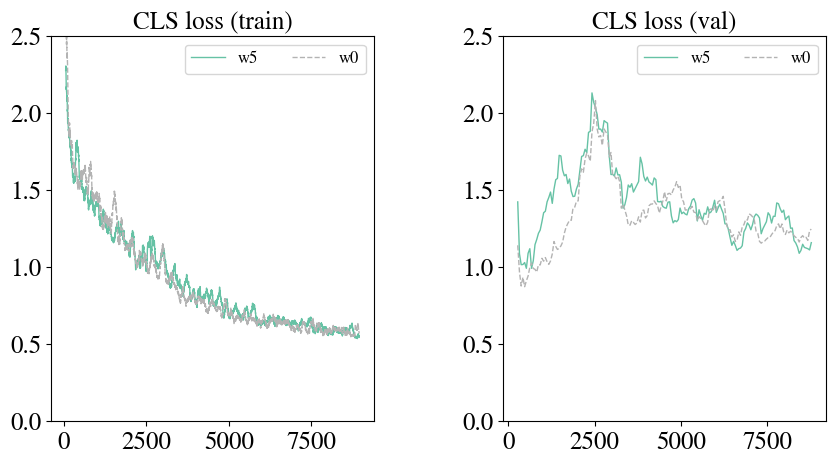

In [64]:
ylim = [0, 2.5]
ncol_legend = 2
prop_legend = {'size': 12}

plt.figure(figsize=(10, 5))
plt.subplot(121)
window = 100
plt.title("CLS loss (train)")
plt.plot(move_average(model1.loss_save["train"]["niter"], window=window), 
        move_average(model1.loss_save["train"]["cls_loss"], window=window), 
        color=cols[0], linestyle=linestyles[0], linewidth=linewidths[0],
        label=f"{model_names[0]}")
plt.plot(move_average(model2.loss_save["train"]["niter"], window=window), 
        move_average(model2.loss_save["train"]["cls_loss"], window=window), 
        color=cols[1], linestyle=linestyles[1], linewidth=linewidths[1],
        label=f"{model_names[1]}")
plt.legend(ncol=ncol_legend, prop=prop_legend)
plt.ylim(*ylim)

plt.subplot(122)
window = 10
plt.title("CLS loss (val)")
plt.plot(move_average(model1.loss_save["val"]["niter"], window=window), 
        move_average([np.mean(v) for v in model1.loss_save["val"]["cls_loss"]], window=window), 
        color=cols[0], linestyle=linestyles[0], linewidth=linewidths[0],
        label=f"{model_names[0]}")
plt.plot(move_average(model2.loss_save["val"]["niter"], window=window), 
        move_average([np.mean(v) for v in model2.loss_save["val"]["cls_loss"]], window=window), 
        color=cols[1], linestyle=linestyles[1], linewidth=linewidths[1],
        label=f"{model_names[1]}")
plt.ylim(*ylim)
plt.legend(ncol=ncol_legend, prop=prop_legend)

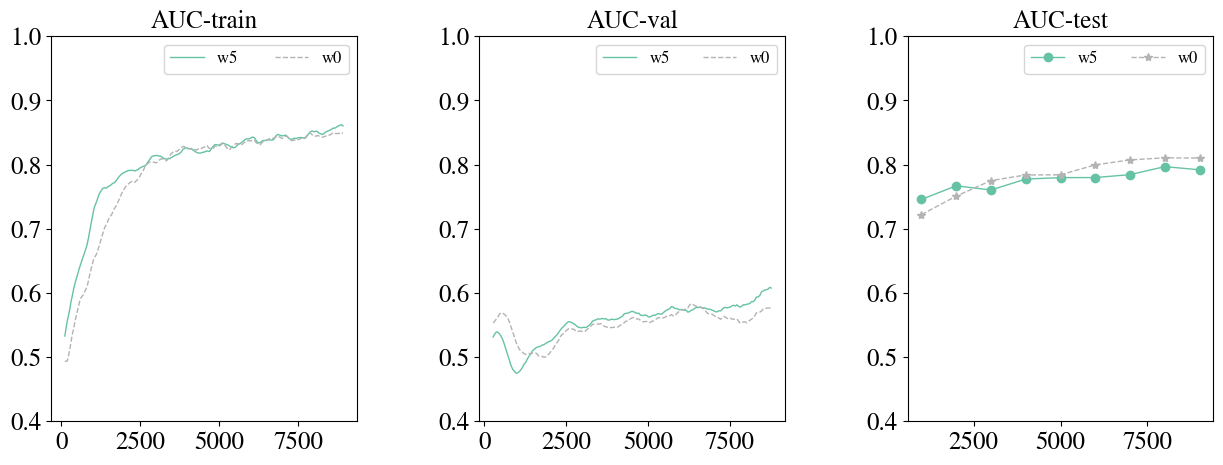

In [65]:
ylim = [0.4, 1]
ncol_legend = 2
prop_legend = {'size': 12}

plt.figure(figsize=(15, 5))

plt.subplot(131)
window = 10
plt.title("AUC-train")
plt.plot(move_average(model1.loss_save["train"]["niter_auc"], window=window), 
        move_average(model1.loss_save["train"]["auc"], window=window), 
        color=cols[0], linestyle=linestyles[0], linewidth=linewidths[0],
        label=f"{model_names[0]} ")
plt.plot(move_average(model2.loss_save["train"]["niter_auc"], window=window), 
        move_average(model2.loss_save["train"]["auc"], window=window), 
        color=cols[1], linestyle=linestyles[1], linewidth=linewidths[1],
        label=f"{model_names[1]}")
plt.legend(ncol=ncol_legend, prop=prop_legend)
plt.ylim(*ylim)

plt.subplot(132)
plt.title("AUC-val")
window = 10
plt.plot(move_average(model1.loss_save["val"]["niter"], window=window), 
        move_average(model1.loss_save["val"]["auc"], window=window), 
        color=cols[0], linestyle=linestyles[0], linewidth=linewidths[0],
        label=f"{model_names[0]}")
plt.plot(move_average(model2.loss_save["val"]["niter"], window=window), 
        move_average(model2.loss_save["val"]["auc"], window=window), 
        color=cols[1], linestyle=linestyles[1], linewidth=linewidths[1],
        label=f"{model_names[1]}")
plt.ylim(*ylim)
plt.legend(ncol=ncol_legend, prop=prop_legend)

plt.subplot(133)
window = 1
plt.title("AUC-test")
plt.plot(
    move_average(model1.loss_save["test"]["niter"], window=window), 
    move_average(model1.loss_save["test"]["auc"], window=window), 
    color=cols[0], linestyle=linestyles[0], linewidth=linewidths[0],
    marker="o",
    label=f"{model_names[0]}")
plt.plot(move_average(model2.loss_save["test"]["niter"], window=window), 
        move_average(model2.loss_save["test"]["auc"], window=window), 
        color=cols[1], linestyle=linestyles[1], linewidth=linewidths[1],
        marker="*",
    label=f"{model_names[1]}")
plt.ylim(*ylim)
plt.legend(ncol=ncol_legend, prop=prop_legend)